### Examples for working with Healpix IFS-FESOM data

This is more or less a copy of IFS example, but with some examples from the ocean variables.

In [1]:
# uncomment below if you see a gribscan module not found error
#!pip install gribscan

In [2]:
#1)uncomment below to install the hackathon python environment (only needed once). 
#2)After installing, refresh the jupyter browser and select as kernel the newly installed one (click on top-right, look for python-HH-hackathon)
#3)You can then comment this line again
#!module use /work/k20200/k202134/hsm-tools/outtake/module; module load python3/hamburg-hackathon; python -m ipykernel install --name python-HH-hackathon --user

In [69]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.feature as cfeature
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import eccodes
import healpy as hp
import os

In [70]:
# check that the right eccodes version is available (>=2.32.5)
eccodes.codes_get_version_info(), eccodes.codes_get_library_path()

({'eccodes': '2.34.1', 'bindings': '1.7.0'},
 '/fastdata/bm1235/python_environments/hamburg-hackathon/lib/libeccodes.so')

#### helpful functions for plotting healpix
##### with thanks to Boris Shapkin and Bimo Niraula (AWI) for the [initial code](https://github.com/nextGEMS/nextGEMS_Cycle3/blob/healpix-plotter/FESOM/HealpixPlotting__BNiraula.ipynb)

In [71]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=Nested, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [72]:
def worldmap(var,cbar,clabel = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label(" ")
        else:
            cbar.set_label(clabel)  

Note, there are a couple of minor updates to this function.

In [73]:
def plot_healpix(data_healpix,
                 proj = 'mercator',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 clabel = None,
                 vmin = None,vmax = None,
                 fill_continent=False,
                 savefig = False,
                savepath = None,
                closefile=False,
                show=True,
                figsize=(14, 10)):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    if (savefig == True) and (os.path.exists(savepath)):
        return
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,clabel=clabel,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=figsize, subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            if fill_continent == True:
                ax.add_feature(
                              cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
                            )
            
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='horizontal', pad=0.03, shrink=0.9)
                if clabel== None: # Set the label for the colorbar
                    cbar.set_label(" ")
                else:
                    cbar.set_label(clabel)  
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=clabel,nest=Nested)
    if savefig == True:
        plt.savefig(savepath,dpi = 150, format = 'png')
    if show == True:
        plt.show()
    if closefile == True:
        plt.close()

In [74]:
# Are we using Nested Healpix or Ring? 
Nested=True

## Get IFS-FESOM (TCo1279-NG5) production scenario data on Healpix grid and create quick plots

In [75]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [76]:
# Production run is the first IFS experiment in the catalog
print(list(cat.IFS))

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']


In [77]:
print(list(cat.IFS['IFS_9-FESOM_5-production']))

['2D_hourly_healpix512', '2D_hourly_healpix512_2020s', '2D_hourly_healpix512_2030s', '2D_hourly_healpix512_2040s', '2D_daily_healpix512_ocean', '3D_hourly_healpix512', '3D_hourly_healpix512_snow', '3D_daily_healpix512_ocean', '2D_monthly_healpix512', '2D_monthly_healpix512_sst_ci_winds', '3D_monthly_healpix512', '3D_monthly_healpix512_snow', '2D_hourly_healpix128', '2D_monthly_0.25deg', '2D_monthly_0.25deg_snow', '2D_monthly_0.25deg_sst_ci_winds', '3D_monthly_0.25deg']


In [78]:
# select the data resolution in space and time you need
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


##### click on 'Data variables' below to see all variables - with units and meta data (first paper icon to the right)

In [79]:
ds

<xarray.Dataset>
Dimensions:        (time: 8990, value: 3145728)
Coordinates:
    lat            (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
    lon            (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2045-01-01
Dimensions without coordinates: value
Data variables:
    avg_mlotst125  (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_siconc     (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sisnthick  (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sithick    (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_siue       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sivn       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_tos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_zos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [80]:
# select random day
data_healpix = ds['avg_tos'][7042,:]

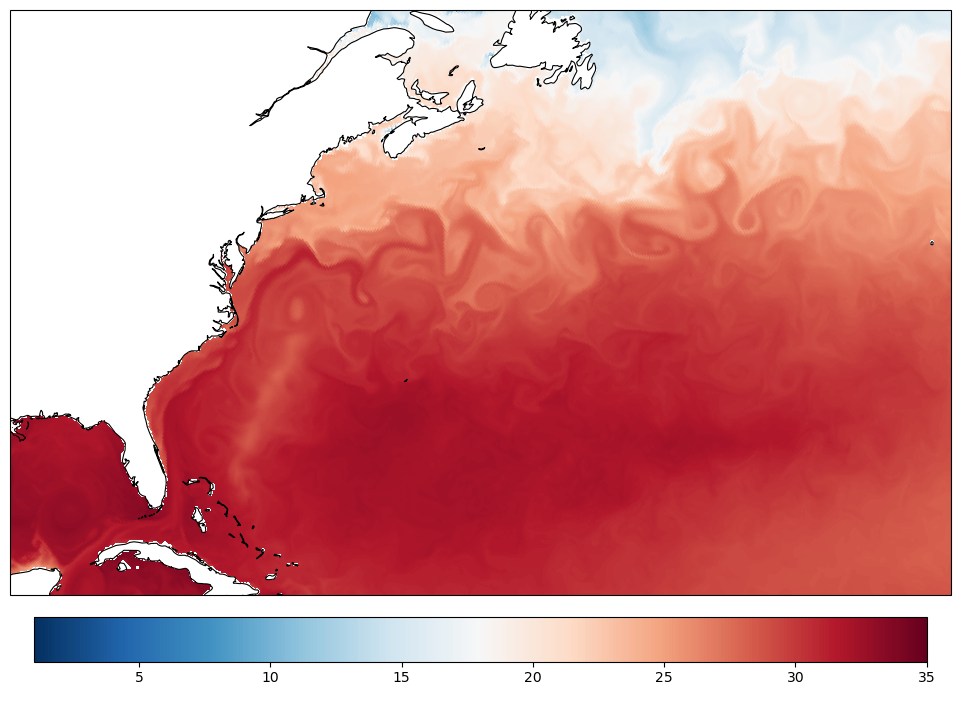

In [81]:
plot_healpix(data_healpix, proj = 'mercator', extent=[-90, -30, 20, 50],\
             cbar=True,
             
             vmin = 1, vmax=35,
                 cmap=cm.RdBu_r,
             figsize=(10, 7)
            )

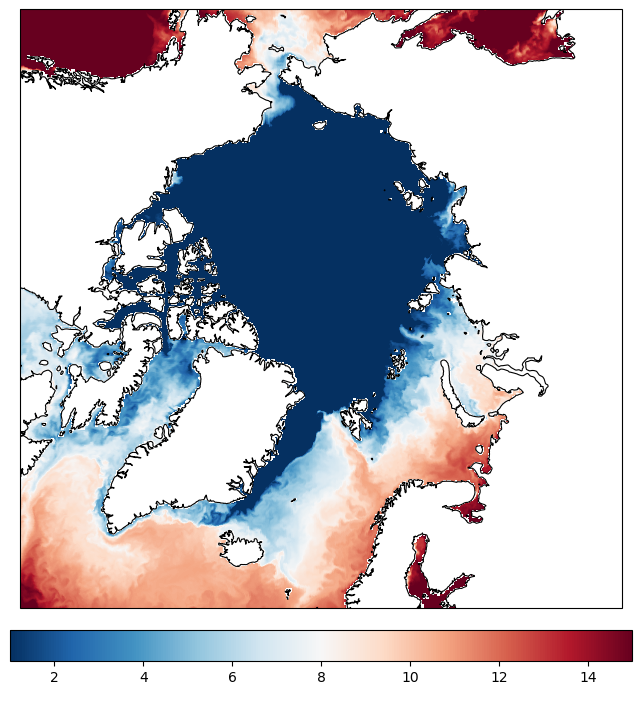

In [82]:
plot_healpix(data_healpix, proj = 'np', extent=[-180, 180, 60, 90],\
             cbar=True,
             vmin = 1, vmax=15,
                 cmap=cm.RdBu_r,
             figsize=(7,7)
            )

In [83]:
data_healpix = ds['avg_siconc'].sel(time='2044-09-15')

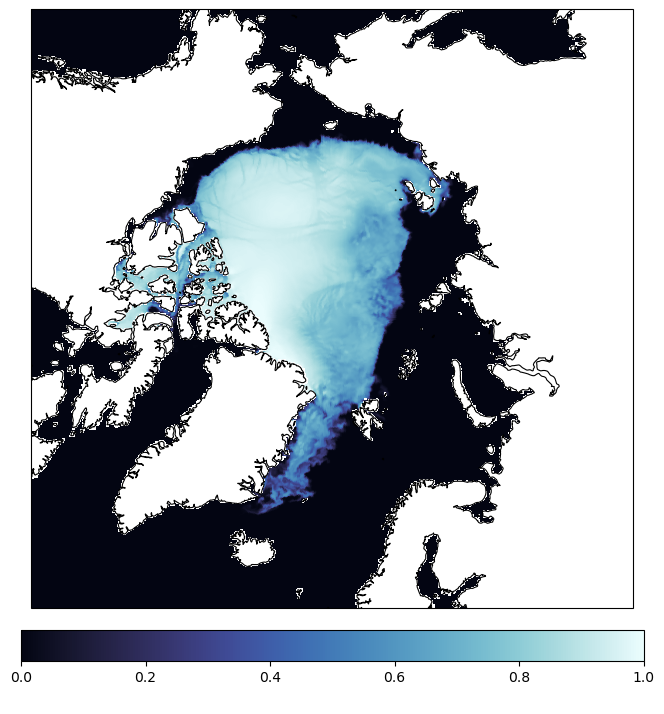

In [84]:
plot_healpix(data_healpix, proj = 'np', extent=[-180, 180, 60, 90],\
             cbar=True,
             vmin = 0, vmax=1,
                 cmap=cmo.ice,
             figsize=(7,7)
            )